In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from time import sleep 

from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim 

In [2]:
torch.cuda.is_available()

True

In [3]:
train_dataset = datasets.CIFAR10(root = "cifar/", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "cifar/", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [38]:
def plotting_losses(losses:torch.Tensor, lamda, baseline):
    plt.figure(figsize=(10,10))
    
    for i, loss in enumerate(losses):
        name = f"lamda= {lamda[i]}" 
        plt.plot(loss.detach(), label=name)
    plt.plot(baseline.detach(), ':', label="lamda=0")
    plt.xscale('linear')
    plt.legend()    
    plt.show()

def plotting_acc(accuracies:torch.Tensor, lamda, baseline):
    plt.figure(figsize=(10,10))
    
    for i, accuracy in enumerate(accuracies):
        name = f"lamda= {lamda[i]}"
        plt.plot(accuracy,  label=name)
    plt.plot(baseline, ':', label="lamda=0")
    plt.xscale('log', base=2)
    plt.legend()
    plt.show()

In [11]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
         
    def forward(self, x):
        x = x.reshape(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def train(model, dataloader, optimizer, reg:bool, lamda):
    for x, y in dataloader:
        x,y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)
        norm = 0
        if reg == True:
            for p in model.parameters():
                norm += torch.norm(p, 'fro')
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y.to(torch.long)) + lamda*(norm*norm)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc


In [13]:
def orthogonal_reg(model_factory, optimizer_factory, dataloader, lamda, epochs):
    lamda_loss = torch.zeros((len(lamda), epochs))
    accuracies = torch.zeros((len(lamda), epochs))
    for i in range(len(lamda)):
        model = model_factory.to('cuda:0')
        optimizer = optimizer_factory 
        for epoch in tqdm(range(epochs)):
            lamda_loss[i, epoch] = train(model, dataloader, optimizer, True, lamda[i])
            accuracies[i, epoch] = accuracy(model, test_loader)
            sleep(0.1)
    return lamda_loss, accuracies

def baseline_noreg(model_factory, optimizer_factory, dataloader, lamda, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory 
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, dataloader, optimizer, False, 0.0)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
    return losses, accuracies

In [14]:
lamda = [0.1, 0.01, 0.001, 0.0001, 0.000001]
model = Network()
optimizer  = optim.Adam(model.parameters(), lr= 0.005, betas= (0.9, 0.95))
reg_losses, reg_accuracies = orthogonal_reg(model, optimizer, train_loader, lamda, 25)

100%|██████████| 25/25 [02:04<00:00,  5.00s/it]


In [15]:
model1 = Network()
optimizer1  = optim.Adam(model1.parameters(), lr= 0.005, betas= (0.9, 0.95))
noreg_losses, noreg_accuracies = baseline_noreg(model1, optimizer1, train_loader, lamda, 25)

100%|██████████| 25/25 [01:57<00:00,  4.71s/it]


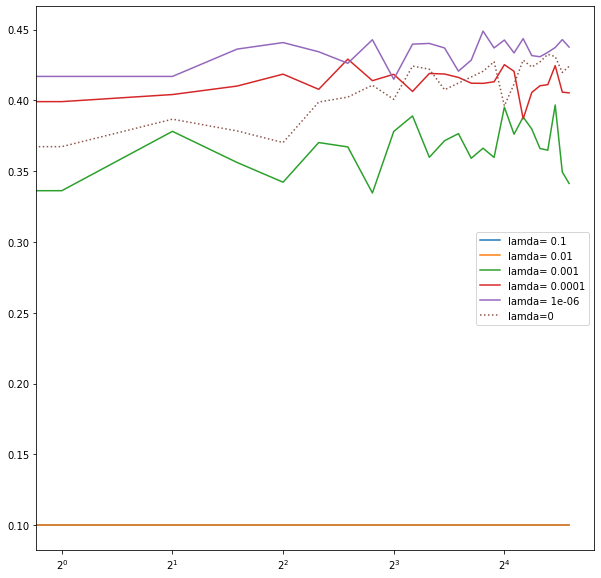

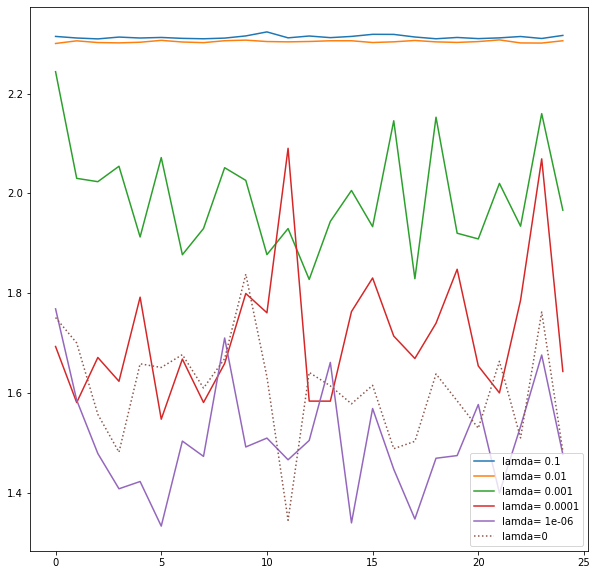

In [39]:
plotting_acc(reg_accuracies, lamda, noreg_accuracies)
plotting_losses(reg_losses, lamda, noreg_losses)

As observed from the plots above the best value of lamda is 1e-6 because it gave loss lower than the baseline network and the accuracy also improved on the unseen data for this value of lamda